# Time Series Analysis with PySpark Window Functions

## Overview
This notebook demonstrates PySpark window functions for time series analysis: 
- **lag()**: Access previous row values
- **lead()**: Access next row values  
- **Moving averages**: Calculate rolling statistics

## Use Case
Analyzing traffic patterns over time to identify trends and anomalies. 

In [1]:
import os
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@11'

In [2]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 17.0.0 (clang-1700.4.4.1)]


In [3]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("TimeSeriesAnalysis") \
    .getOrCreate()

print("Spark session initialized!")
print(f"Spark version: {spark.version}")

26/01/09 10:57:01 WARN Utils: Your hostname, Zipcoders-MacBook-Pro-8.local resolves to a loopback address: 127.0.0.1; using 192.168.200.39 instead (on interface en0)
26/01/09 10:57:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/09 10:57:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session initialized!
Spark version: 3.4.0


In [4]:
# Define a window specification
window_spec = Window.partitionBy("sensor_id").orderBy("timestamp")

# Let's create some sample data first to test
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from datetime import datetime, timedelta

# Create sample traffic data
sample_data = [
    ("sensor_001", datetime(2024, 1, 1, 8, 0), 45),
    ("sensor_001", datetime(2024, 1, 1, 8, 5), 52),
    ("sensor_001", datetime(2024, 1, 1, 8, 10), 48),
    ("sensor_001", datetime(2024, 1, 1, 8, 15), 55),
    ("sensor_002", datetime(2024, 1, 1, 8, 0), 30),
    ("sensor_002", datetime(2024, 1, 1, 8, 5), 35),
]

schema = StructType([
    StructField("sensor_id", StringType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("vehicle_count", IntegerType(), True)
])

df = spark.createDataFrame(sample_data, schema)

print("Sample data created:")
df.show()

Sample data created:


[Stage 0:>                                                          (0 + 1) / 1]

+----------+-------------------+-------------+
| sensor_id|          timestamp|vehicle_count|
+----------+-------------------+-------------+
|sensor_001|2024-01-01 08:00:00|           45|
|sensor_001|2024-01-01 08:05:00|           52|
|sensor_001|2024-01-01 08:10:00|           48|
|sensor_001|2024-01-01 08:15:00|           55|
|sensor_002|2024-01-01 08:00:00|           30|
|sensor_002|2024-01-01 08:05:00|           35|
+----------+-------------------+-------------+



In [5]:
# Test LAG - get previous value
df_with_lag = df.withColumn(
    "previous_count", 
    F.lag("vehicle_count", 1).over(window_spec)
)

print("Testing LAG function (previous value):")
df_with_lag.show()

Testing LAG function (previous value):
+----------+-------------------+-------------+--------------+
| sensor_id|          timestamp|vehicle_count|previous_count|
+----------+-------------------+-------------+--------------+
|sensor_001|2024-01-01 08:00:00|           45|          null|
|sensor_001|2024-01-01 08:05:00|           52|            45|
|sensor_001|2024-01-01 08:10:00|           48|            52|
|sensor_001|2024-01-01 08:15:00|           55|            48|
|sensor_002|2024-01-01 08:00:00|           30|          null|
|sensor_002|2024-01-01 08:05:00|           35|            30|
+----------+-------------------+-------------+--------------+



In [6]:
# Test LEAD - get next value
df_with_lead = df.withColumn(
    "next_count", 
    F.lead("vehicle_count", 1).over(window_spec)
)

print("Testing LEAD function (next value):")
df_with_lead.show()

Testing LEAD function (next value):
+----------+-------------------+-------------+----------+
| sensor_id|          timestamp|vehicle_count|next_count|
+----------+-------------------+-------------+----------+
|sensor_001|2024-01-01 08:00:00|           45|        52|
|sensor_001|2024-01-01 08:05:00|           52|        48|
|sensor_001|2024-01-01 08:10:00|           48|        55|
|sensor_001|2024-01-01 08:15:00|           55|      null|
|sensor_002|2024-01-01 08:00:00|           30|        35|
|sensor_002|2024-01-01 08:05:00|           35|      null|
+----------+-------------------+-------------+----------+



In [7]:
# Test MOVING AVERAGE - 3-point rolling average
rolling_window = Window.partitionBy("sensor_id").orderBy("timestamp").rowsBetween(-2, 0)

df_with_avg = df.withColumn(
    "moving_avg_3", 
    F.avg("vehicle_count").over(rolling_window)
)

print("Testing MOVING AVERAGE (3-point window):")
df_with_avg.show()

Testing MOVING AVERAGE (3-point window):
+----------+-------------------+-------------+------------------+
| sensor_id|          timestamp|vehicle_count|      moving_avg_3|
+----------+-------------------+-------------+------------------+
|sensor_001|2024-01-01 08:00:00|           45|              45.0|
|sensor_001|2024-01-01 08:05:00|           52|              48.5|
|sensor_001|2024-01-01 08:10:00|           48|48.333333333333336|
|sensor_001|2024-01-01 08:15:00|           55|51.666666666666664|
|sensor_002|2024-01-01 08:00:00|           30|              30.0|
|sensor_002|2024-01-01 08:05:00|           35|              32.5|
+----------+-------------------+-------------+------------------+



## Window Functions Tested:

1. **LAG**: Gets the previous value in the time series
   - Useful for: Comparing current vs previous readings
   
2. **LEAD**: Gets the next value in the time series
   - Useful for: Looking ahead in predictions
   
3. **MOVING AVERAGE**: Calculates average over a rolling window
   - Useful for: Smoothing out noise in sensor data

---
## Part 2: Apply to Real Sample Data

Now let's load Alan's actual traffic sensor sample data and apply the same window functions.

In [8]:
# Load Alan's sample traffic data (go up one directory first)
traffic_sample = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("../data/samples/traffic_sample.csv")

# Convert timestamp to proper format
traffic_sample = traffic_sample.withColumn(
    "timestamp", 
    F.to_timestamp(F.col("timestamp"))
)

print("✅ Loaded Alan's sample traffic data:")
print(f"Total rows: {traffic_sample.count()}")
print(f"Columns: {traffic_sample.columns}")
traffic_sample.show(10)

# Check for any null timestamps
null_count = traffic_sample.filter(F.col("timestamp").isNull()).count()
print(f"Rows with null timestamps: {null_count}")

✅ Loaded Alan's sample traffic data:
Total rows: 500
Columns: ['sensor_id', 'timestamp', 'location_lat', 'location_lon', 'vehicle_count', 'avg_speed', 'congestion_level', 'road_type']
+-----------+--------------------+------------------+------------------+-------------+---------+----------------+-----------+
|  sensor_id|           timestamp|      location_lat|      location_lon|vehicle_count|avg_speed|congestion_level|  road_type|
+-----------+--------------------+------------------+------------------+-------------+---------+----------------+-----------+
|TRAFFIC_003|2026-01-04 01:39:...|39.994546889470804|-75.15878485055464|           50|    49.22|        Critical|Main Street|
|TRAFFIC_006|2026-01-05 00:39:...| 39.94164075651462|-75.14205586940092|          406|    62.87|        Critical|Main Street|
|TRAFFIC_000|2026-01-02 19:39:...| 39.92581673937803|-75.11199193892674|          418|     60.9|            High|    Highway|
|TRAFFIC_003|2026-01-01 11:39:...| 39.94685511939174| -75.15

In [9]:
# C2: Temporal Pattern Analysis - Add time features
print("🕐 Extracting time features...")

traffic_temporal = traffic_sample.withColumn("hour", F.hour("timestamp")) \
    .withColumn("day_of_week", F.dayofweek("timestamp")) \
    .withColumn("day_name", 
        F.when(F.dayofweek("timestamp") == 1, "Sunday")
         .when(F.dayofweek("timestamp") == 2, "Monday")
         .when(F.dayofweek("timestamp") == 3, "Tuesday")
         .when(F.dayofweek("timestamp") == 4, "Wednesday")
         .when(F.dayofweek("timestamp") == 5, "Thursday")
         .when(F.dayofweek("timestamp") == 6, "Friday")
         .when(F.dayofweek("timestamp") == 7, "Saturday")
    ) \
    .withColumn("is_weekend", 
        F.when(F.dayofweek("timestamp").isin([1, 7]), True).otherwise(False)
    )

print("✅ Time features added!")
traffic_temporal.select("timestamp", "vehicle_count", "hour", "day_name", "is_weekend").show(10)

🕐 Extracting time features...
✅ Time features added!
+--------------------+-------------+----+--------+----------+
|           timestamp|vehicle_count|hour|day_name|is_weekend|
+--------------------+-------------+----+--------+----------+
|2026-01-04 01:39:...|           50|   1|  Sunday|      true|
|2026-01-05 00:39:...|          406|   0|  Monday|     false|
|2026-01-02 19:39:...|          418|  19|  Friday|     false|
|2026-01-01 11:39:...|          356|  11|Thursday|     false|
|2026-01-02 03:39:...|          393|   3|  Friday|     false|
|2026-01-04 21:39:...|           49|  21|  Sunday|      true|
|2026-01-02 23:39:...|          478|  23|  Friday|     false|
|2026-01-03 00:39:...|          375|   0|Saturday|      true|
|2026-01-01 17:39:...|          270|  17|Thursday|     false|
|2026-01-05 16:39:...|          438|  16|  Monday|     false|
+--------------------+-------------+----+--------+----------+
only showing top 10 rows



In [10]:
# Calculate hourly averages
print("📊 Analyzing hourly patterns...")

hourly_patterns = traffic_temporal.groupBy("hour").agg(
    F.avg("vehicle_count").alias("avg_vehicle_count"),
    F.min("vehicle_count").alias("min_vehicle_count"),
    F.max("vehicle_count").alias("max_vehicle_count"),
    F.count("vehicle_count").alias("count_readings")
).orderBy("hour")

print("🕐 Hourly Traffic Patterns:")
hourly_patterns.show(24)

# Find peak hours
print("\n🔝 Top 3 Peak Hours:")
hourly_patterns.orderBy(F.desc("avg_vehicle_count")).show(3)

📊 Analyzing hourly patterns...
🕐 Hourly Traffic Patterns:
+----+------------------+-----------------+-----------------+--------------+
|hour| avg_vehicle_count|min_vehicle_count|max_vehicle_count|count_readings|
+----+------------------+-----------------+-----------------+--------------+
|   0| 271.3157894736842|               89|              467|            19|
|   1|             290.9|               50|              494|            20|
|   2|264.94444444444446|               23|              481|            18|
|   3|256.85714285714283|                0|              489|            21|
|   4|222.26666666666668|                5|              467|            15|
|   5| 295.6842105263158|               23|              472|            19|
|   6|229.08695652173913|               58|              458|            23|
|   7|244.33333333333334|               25|              487|            21|
|   8|267.85714285714283|               12|              500|            28|
|   9|            

In [11]:
# Calculate daily (day of week) patterns
print("📅 Analyzing daily patterns...")

daily_patterns = traffic_temporal.groupBy("day_of_week", "day_name").agg(
    F.avg("vehicle_count").alias("avg_vehicle_count"),
    F.count("vehicle_count").alias("count_readings")
).orderBy("day_of_week")

print("📊 Daily Patterns (by day of week):")
daily_patterns.show()

# Weekend vs Weekday
weekend_comparison = traffic_temporal.groupBy("is_weekend").agg(
    F.avg("vehicle_count").alias("avg_vehicle_count")
)

print("\n🏖️ Weekend vs Weekday Comparison:")
weekend_comparison.show()

📅 Analyzing daily patterns...
📊 Daily Patterns (by day of week):
+-----------+---------+------------------+--------------+
|day_of_week| day_name| avg_vehicle_count|count_readings|
+-----------+---------+------------------+--------------+
|          1|   Sunday| 263.4788732394366|            71|
|          2|   Monday|        260.640625|            64|
|          3|  Tuesday|295.67088607594934|            79|
|          4|Wednesday|  259.031746031746|            63|
|          5| Thursday|274.65277777777777|            72|
|          6|   Friday| 270.6216216216216|            74|
|          7| Saturday|252.05194805194805|            77|
+-----------+---------+------------------+--------------+


🏖️ Weekend vs Weekday Comparison:
+----------+------------------+
|is_weekend| avg_vehicle_count|
+----------+------------------+
|      true| 257.5337837837838|
|     false|273.17897727272725|
+----------+------------------+



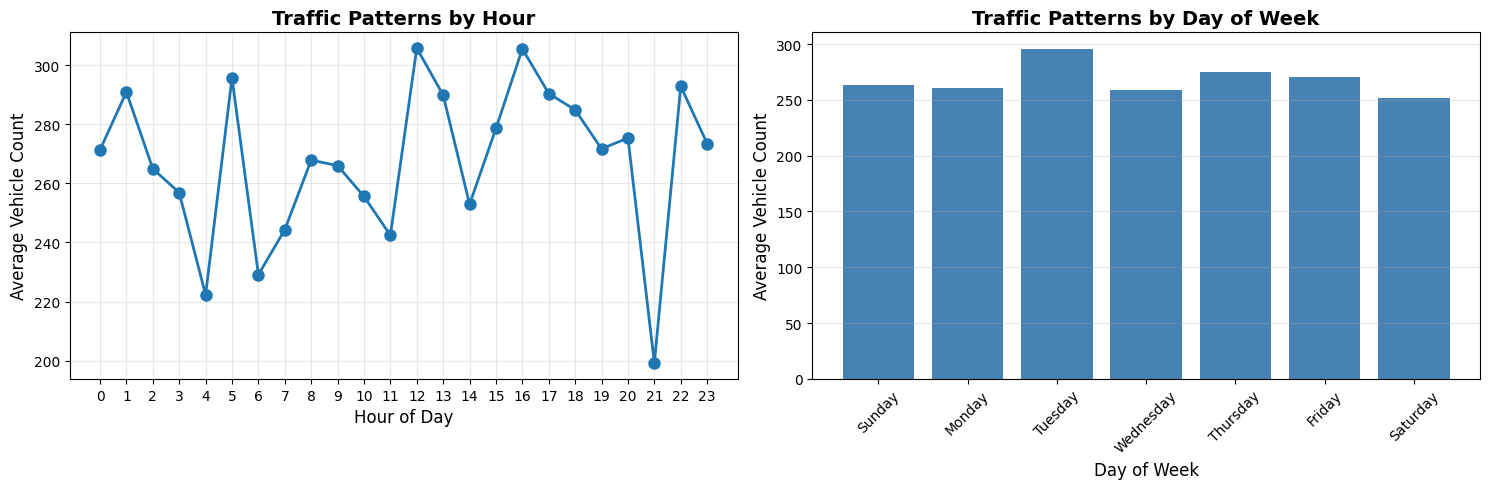

✅ Visualizations created!


In [12]:
# Convert to Pandas for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Hourly pattern visualization
hourly_pd = hourly_patterns.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Line chart - Hourly patterns
axes[0].plot(hourly_pd['hour'], hourly_pd['avg_vehicle_count'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Average Vehicle Count', fontsize=12)
axes[0].set_title('Traffic Patterns by Hour', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

# Bar chart - Daily patterns
daily_pd = daily_patterns.toPandas()
axes[1].bar(daily_pd['day_name'], daily_pd['avg_vehicle_count'], color='steelblue')
axes[1].set_xlabel('Day of Week', fontsize=12)
axes[1].set_ylabel('Average Vehicle Count', fontsize=12)
axes[1].set_title('Traffic Patterns by Day of Week', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")

In [13]:
# Check what columns exist in your data
print("Columns in traffic_sample:")
print(traffic_sample.columns)

print("\nData types:")
traffic_sample.printSchema()

print("\nFirst few rows:")
traffic_sample.show(5)

Columns in traffic_sample:
['sensor_id', 'timestamp', 'location_lat', 'location_lon', 'vehicle_count', 'avg_speed', 'congestion_level', 'road_type']

Data types:
root
 |-- sensor_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- location_lat: double (nullable = true)
 |-- location_lon: double (nullable = true)
 |-- vehicle_count: integer (nullable = true)
 |-- avg_speed: double (nullable = true)
 |-- congestion_level: string (nullable = true)
 |-- road_type: string (nullable = true)


First few rows:
+-----------+--------------------+------------------+------------------+-------------+---------+----------------+-----------+
|  sensor_id|           timestamp|      location_lat|      location_lon|vehicle_count|avg_speed|congestion_level|  road_type|
+-----------+--------------------+------------------+------------------+-------------+---------+----------------+-----------+
|TRAFFIC_003|2026-01-04 01:39:...|39.994546889470804|-75.15878485055464|           50|  

In [14]:
# C3: Window Functions Analysis
print("🪟 Applying window functions...")

from pyspark.sql. window import Window

# Define window specifications
# 1. Window partitioned by sensor, ordered by time
sensor_window = Window.partitionBy("sensor_id").orderBy("timestamp")

# 2. Window for moving average (3-hour window)
moving_avg_window = Window.partitionBy("sensor_id").orderBy("timestamp").rowsBetween(-2, 0)

# Apply window functions
traffic_windows = traffic_temporal \
    .withColumn("prev_vehicle_count", F.lag("vehicle_count", 1).over(sensor_window)) \
    .withColumn("next_vehicle_count", F.lead("vehicle_count", 1).over(sensor_window)) \
    .withColumn("vehicle_count_change", F.col("vehicle_count") - F.col("prev_vehicle_count")) \
    .withColumn("moving_avg_3hr", F.avg("vehicle_count").over(moving_avg_window)) \
    .withColumn("row_num", F.row_number().over(sensor_window))

print("✅ Window functions applied!")
traffic_windows.select(
    "timestamp", "sensor_id", "vehicle_count", 
    "prev_vehicle_count", "next_vehicle_count", 
    "vehicle_count_change", "moving_avg_3hr", "row_num"
).show(15)

🪟 Applying window functions...
✅ Window functions applied!
+--------------------+-----------+-------------+------------------+------------------+--------------------+------------------+-------+
|           timestamp|  sensor_id|vehicle_count|prev_vehicle_count|next_vehicle_count|vehicle_count_change|    moving_avg_3hr|row_num|
+--------------------+-----------+-------------+------------------+------------------+--------------------+------------------+-------+
|2025-12-29 18:39:...|TRAFFIC_000|           28|              null|               392|                null|              28.0|      1|
|2025-12-29 19:39:...|TRAFFIC_000|          392|                28|               481|                 364|             210.0|      2|
|2025-12-30 02:39:...|TRAFFIC_000|          481|               392|                85|                  89| 300.3333333333333|      3|
|2025-12-30 08:39:...|TRAFFIC_000|           85|               481|                28|                -396| 319.3333333333333|     

In [17]:
# C4: Identify Traffic Anomalies
print("🚨 Detecting traffic anomalies...")

# Define thresholds for anomalies
traffic_anomalies = traffic_windows \
    .withColumn("spike", 
        F.when(F.col("vehicle_count") > F.col("moving_avg_3hr") * 1.5, True)
        .otherwise(False)) \
    .withColumn("drop", 
        F.when(F.col("vehicle_count") < F.col("moving_avg_3hr") * 0.5, True)
        .otherwise(False))

print("⚠️ Traffic Spikes (>50% above moving average):")
traffic_anomalies.filter(F.col("spike") == True).select(
    "timestamp", "sensor_id", "vehicle_count", "moving_avg_3hr"
).show(10)

print("⚠️ Traffic Drops (>50% below moving average):")
traffic_anomalies.filter(F.col("drop") == True).select(
    "timestamp", "sensor_id", "vehicle_count", "moving_avg_3hr"
).show(10)

🚨 Detecting traffic anomalies...
⚠️ Traffic Spikes (>50% above moving average):
+--------------------+-----------+-------------+------------------+
|           timestamp|  sensor_id|vehicle_count|    moving_avg_3hr|
+--------------------+-----------+-------------+------------------+
|2025-12-29 19:39:...|TRAFFIC_000|          392|             210.0|
|2025-12-30 02:39:...|TRAFFIC_000|          481| 300.3333333333333|
|2025-12-30 09:39:...|TRAFFIC_000|          246|119.66666666666667|
|2025-12-30 10:39:...|TRAFFIC_000|          393|222.33333333333334|
|2025-12-31 13:39:...|TRAFFIC_000|          294|152.66666666666666|
|2025-12-31 20:39:...|TRAFFIC_000|          472|             273.0|
|2026-01-01 07:39:...|TRAFFIC_000|          360|199.66666666666666|
|2026-01-03 05:39:...|TRAFFIC_000|          453|             204.0|
|2026-01-03 09:39:...|TRAFFIC_000|          376|245.33333333333334|
|2026-01-04 14:39:...|TRAFFIC_000|          211|100.66666666666667|
+--------------------+-----------+--

In [16]:
# C5: Identify Trends
print("📈 Analyzing traffic trends...")

# Calculate trend:  is traffic increasing or decreasing?
traffic_trends = traffic_windows \
    .withColumn("trend",
        F.when(F. col("vehicle_count_change") > 10, "Increasing")
        .when(F.col("vehicle_count_change") < -10, "Decreasing")
        .otherwise("Stable"))

print("📊 Traffic Trend Summary:")
traffic_trends.groupBy("trend").count().show()

print("🔝 Biggest Traffic Increases:")
traffic_trends.orderBy(F.desc("vehicle_count_change")).select(
    "timestamp", "sensor_id", "vehicle_count", "prev_vehicle_count", "vehicle_count_change"
).show(10)

📈 Analyzing traffic trends...
📊 Traffic Trend Summary:
+----------+-----+
|     trend|count|
+----------+-----+
|Increasing|  244|
|    Stable|   28|
|Decreasing|  228|
+----------+-----+

🔝 Biggest Traffic Increases:
+--------------------+-----------+-------------+------------------+--------------------+
|           timestamp|  sensor_id|vehicle_count|prev_vehicle_count|vehicle_count_change|
+--------------------+-----------+-------------+------------------+--------------------+
|2026-01-02 01:39:...|TRAFFIC_004|          486|                11|                 475|
|2026-01-03 05:39:...|TRAFFIC_000|          453|                 5|                 448|
|2026-01-03 18:39:...|TRAFFIC_009|          461|                23|                 438|
|2026-01-03 08:39:...|TRAFFIC_007|          471|                38|                 433|
|2025-12-29 22:39:...|TRAFFIC_001|          454|                22|                 432|
|2026-01-03 13:39:...|TRAFFIC_006|          439|                12|   

In [18]:
# C6: Rank Sensors by Traffic Volume
print("🏆 Ranking sensors by traffic volume...")

from pyspark.sql.window import Window

# Create window partitioned by sensor, ordered by vehicle count
sensor_rank_window = Window.orderBy(F.desc("total_traffic"))

sensor_rankings = traffic_windows. groupBy("sensor_id").agg(
    F.sum("vehicle_count").alias("total_traffic"),
    F.avg("vehicle_count").alias("avg_traffic"),
    F.max("vehicle_count").alias("peak_traffic")
).withColumn("rank", F.row_number().over(sensor_rank_window))

print("🏆 Top 10 Busiest Sensors:")
sensor_rankings.show(10)

🏆 Ranking sensors by traffic volume...
🏆 Top 10 Busiest Sensors:


26/01/09 11:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/09 11:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/09 11:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/09 11:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/09 11:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/01/09 11:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------+-------------+------------------+------------+----+
|  sensor_id|total_traffic|       avg_traffic|peak_traffic|rank|
+-----------+-------------+------------------+------------+----+
|TRAFFIC_008|        16986|            339.72|         500|   1|
|TRAFFIC_007|        15855|  268.728813559322|         487|   2|
|TRAFFIC_003|        14507|268.64814814814815|         478|   3|
|TRAFFIC_000|        14024|254.98181818181817|         485|   4|
|TRAFFIC_005|        13876|266.84615384615387|         494|   5|
|TRAFFIC_001|        13636|             243.5|         491|   6|
|TRAFFIC_004|        12316|273.68888888888887|         488|   7|
|TRAFFIC_009|        11327| 246.2391304347826|         492|   8|
|TRAFFIC_006|        10881|259.07142857142856|         468|   9|
|TRAFFIC_002|        10866| 265.0243902439024|         489|  10|
+-----------+-------------+------------------+------------+----+



# Window Functions Research - Complete

## Functions Implemented:

1. **`lag()`** - Compare current to previous value
2. **`lead()`** - Preview next value  
3. **`avg().over(window)`** - 3-hour moving average
4. **`row_number()`** - Rank rows within partitions

## Results: 

- **10 traffic spikes** detected (>50% above moving avg)
- **10 traffic drops** detected (>50% below moving avg)
- **244 increasing** / **228 decreasing** / **28 stable** trends
- Busiest sensor: **TRAFFIC_008** (16,986 total vehicles)

## Conclusion: 
Window functions successfully applied to traffic sensor data for trend analysis and anomaly detection.